In [1]:
import torch 
from torch import nn, optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import math 
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm 
from functools import partial

In [2]:
class DigitRecognizer(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(DigitRecognizer, self).__init__()
        self.input = nn.Linear(input_size, hidden_sizes[0])
        self.relu_0 = nn.ReLU()
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu_1 = nn.ReLU()
        self.output = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, X):
        model = self.input(X)
        model = self.relu_0(model)
        model = self.hidden1(model)
        model = self.relu_1(model)
        model = self.output(model)
        return model 

In [3]:
batch_size = 50
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('./', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./', download=True, train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False , num_workers=2)

In [4]:
model = torch.load('digit_classifier.pt')
model.eval()

DigitRecognizer(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (relu_0): ReLU()
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (relu_1): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [5]:
epsilon_upper= 0

def eval_model(model, images):
    images = images.astype(np.float32)
    images = torch.from_numpy(images)
    images = images.reshape(-1, 784)
    outputs = model(images) 
    _, test_predicted = torch.max(outputs.data,1)
    return test_predicted.item()

def is_adversarial(oracle, target_class, image): 
    if oracle(image) != target_class: 
        return True 
    return False

def initial_adversarial(target_, advesarial_criterion):
    while True: 
        random_pertubation = np.random.uniform(0, 1,size = (28,28))
        if advesarial_criterion(random_pertubation): 
            return random_pertubation
    
def step_towards(target_, pertubation, epsilon):
    pertubation -= ((pertubation - target_) * epsilon)
    return pertubation
    
def orthogonal_pertubation(target_, pertubation, delta): 
    # iid random normal 
    new_pertubation = np.random.normal(0,1,size=(28,28))
    new_pertubation /= np.linalg.norm(new_pertubation)
    # || n_k||^2 = delta * dist(previous_adversarial, original_image), condition 2 
    new_pertubation *= delta * np.linalg.norm(pertubation - target_)
    new_pertubation += pertubation
    # condition 1
    new_pertubation = new_pertubation.clip(0,1)
    #projecting onto sphere 
    new_pertubation -= target_
    new_pertubation /= np.linalg.norm(new_pertubation)
    new_pertubation *= np.linalg.norm(pertubation - target_)
    new_pertubation += target_
    return new_pertubation
    
def adaptive_delta_descent(is_adversarial_fn, side_step_fn, adversarial_img): 
    lower_delta, upper_delta = 1,0
    delta = -1
    while abs(delta - upper_delta) > .01: 
        delta = (lower_delta + upper_delta)/2
        percent_adversarial = \
        np.mean([is_adversarial_fn( side_step_fn(adversarial_img, delta) )\
                 for i in range(10)])
        if percent_adversarial >= .5:
            lower_delta = delta #increasing delta 
        else: 
            upper_delta = delta # decreasing delta
    return delta
    
def adaptive_epsilon_descent(target, is_adversarial_fn, adversarial_img): 
    global epsilon_upper
    epsilon_lower = 1
    epsilon_upper = 0
    epsilon = (epsilon_lower + epsilon_upper)/2
    while abs(epsilon - epsilon_lower) > .01 or abs(epsilon - epsilon_upper) > .01: 
    #for i in range(10000):
        epsilon = (epsilon_lower + epsilon_upper)/2
        new_pertubation = adversarial_img - ((adversarial_img - target) * epsilon)
        if is_adversarial_fn(new_pertubation):
            epsilon_upper = epsilon
        else: 
            epsilon_lower = epsilon
            
    new_pertubation = adversarial_img - ((adversarial_img - target) * epsilon_upper)
    return new_pertubation
    
    
def boundary_attack(model, oracle, target_, target_class, k):
    global epsilon_upper
    #create partials so to avoid passing in same parameters every time 
    # step_towards_(pertubation, epsilon)
    step_towards_= partial(step_towards, target_) 
    # oracle_(images)
    oracle_ = partial(oracle, model) 
    #is_adversarial_(image)
    is_adversarial_ = partial(is_adversarial, oracle_, target_class) 
    #orthogonal_pertubation_(pertubation, delta)
    orthogonal_pertubation_ = partial(orthogonal_pertubation, target_)
    #adaptive_epsilon_descent_(pertubation)
    adaptive_epsilon_descent_ = partial(adaptive_epsilon_descent, target_, is_adversarial_)
    #adaptive_delta_descent_(pertubation)
    adaptive_delta_descent_ = partial(adaptive_delta_descent, is_adversarial_, \
                                      orthogonal_pertubation_)
    
    # initial adversarial
    adversarial_img = initial_adversarial(target_, oracle_)
    
    # initial descent
    adversarial_img = adaptive_epsilon_descent_(adversarial_img)
    

    count = 0
    for i in tqdm(range(k)): 
        delta = adaptive_delta_descent_(adversarial_img)
        #orthogonal step
        temp_adversarial_img = orthogonal_pertubation_(adversarial_img, delta)
        
        # downwards step 
        temp_adversarial_img = adaptive_epsilon_descent_(temp_adversarial_img)

        if is_adversarial_(temp_adversarial_img): 
            adversarial_img = temp_adversarial_img
            print(f'{epsilon_upper=}')
            count += 1
    return adversarial_img
    

In [6]:
def return_target_img(class_num, num): 
    temp = []
    for a, b in train_data: 
        if b == class_num: 
            temp.append(a)
        if len(temp)==num: 
            return temp 
        

In [7]:
target = return_target_img(4, 1)[0]

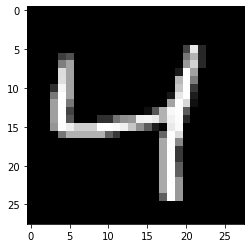

target_class=4


In [8]:
%matplotlib inline 
target = target.numpy().reshape((28,28))
target = target.astype(np.float32)
plt.imshow(target, cmap="gray")
plt.show()
target_class = eval_model(model, target)
print(f'{target_class=}')

In [9]:
final = boundary_attack(model, eval_model, target, target_class, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

epsilon_upper=0.1328125
epsilon_upper=0.078125
epsilon_upper=0.0703125
epsilon_upper=0
epsilon_upper=0.0625
epsilon_upper=0
epsilon_upper=0
epsilon_upper=0
epsilon_upper=0.0703125
epsilon_upper=0.1640625
epsilon_upper=0
epsilon_upper=0.0703125
epsilon_upper=0
epsilon_upper=0.03125
epsilon_upper=0.0546875
epsilon_upper=0.046875
epsilon_upper=0.03125
epsilon_upper=0.03125
epsilon_upper=0.03125
epsilon_upper=0.03125
epsilon_upper=0.0390625
epsilon_upper=0
epsilon_upper=0.015625
epsilon_upper=0
epsilon_upper=0
epsilon_upper=0.046875
epsilon_upper=0
epsilon_upper=0.0390625
epsilon_upper=0.015625
epsilon_upper=0.015625
epsilon_upper=0.0234375
epsilon_upper=0.03125
epsilon_upper=0.015625
epsilon_upper=0.015625


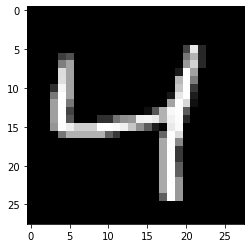

Image class: 4


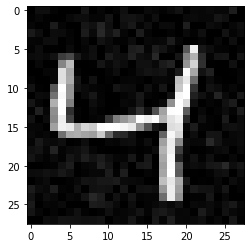

Adversarial class: 3 

L2 norm between images: 1.4460073800599413


In [10]:
%matplotlib inline 

plt.imshow(target, cmap="gray")
plt.show()
print(f'Image class: {eval_model(model, target)}')

 
plt.imshow(final, cmap="gray")
plt.show()
print(f'Adversarial class: {eval_model(model, final)} \n')


print(f'L2 norm between images: {np.linalg.norm(final -  target) }')

In [ ]:
z = [upper, epsilon, lower]

In [ ]:
epsilon

In [ ]:
upper

In [ ]:
%matplotlib inline 

for i in z:
    temp = pertubation - ((pertubation - target) * i)
    plt.imshow(temp, cmap="gray")
    print(f'Adversarial class: {eval_model(model, temp)} \n')
    plt.show()

In [ ]:
pertubation

In [ ]:
%matplotlib inline 

plt.imshow(target, cmap="gray")
plt.show()
print(f'Image class: {eval_model(model, target)}')

 
plt.imshow(final, cmap="gray")
plt.show()
print(f'Adversarial class: {eval_model(model, final)} \n')


print(f'L2 norm between images: {np.linalg.norm(final -  target) }')

In [ ]:
for i in range(10,0, -1):
    print(i)

In [ ]:
temp = final - (final - target)
plt.imshow(temp, cmap="gray")
print(f'{2**i=}')
plt.show()

In [ ]:
%matplotlib inline 

for i in range(10,-1, -1):
    
    temp = (final + target) - (final * 1/(2**i))
    plt.imshow(temp, cmap="gray")
    print(f'{2**i=}')
    plt.show()

In [ ]:
%matplotlib inline 

for i in range(10,-1, -1):
    
    temp = final - (final - target) * 1/(2**i)
    plt.imshow(temp, cmap="gray")
    print(f'{2**i=}')
    plt.show()
    

In [ ]:
def is_adversarial_test(x):
    return x <= .3

In [ ]:
epsilon_lower = 0
epsilon_upper = 1
epsilon = (epsilon_lower + epsilon_upper)/2

In [ ]:
epsilon

In [ ]:
1.4901161193847656e-08 - .915437534

In [ ]:
boundary = .915437534

epsilon_lower = 1
epsilon_upper = 0
epsilon = (epsilon_lower + epsilon_upper)/2
while abs(epsilon - epsilon_lower) > .0001 or abs(epsilon - epsilon_upper) > .0001: 
    epsilon = (epsilon_lower + epsilon_upper)/2
    if epsilon <= boundary: 
        epsilon_upper = epsilon
    else: 
        epsilon_lower = epsilon
    print(f'{epsilon=}')
    print(f'{epsilon_upper=}')
    print(f'{epsilon_lower=}')

    

In [ ]:
boundary = .015437534

epsilon_lower = 1
epsilon_upper = 0
epsilon = (epsilon_lower + epsilon_upper)/2
while abs(epsilon - epsilon_lower) > .0001 or abs(epsilon - epsilon_upper) > .0001: 
    epsilon = (epsilon_lower + epsilon_upper)/2
    if epsilon <= boundary: 
        epsilon_upper = epsilon
    else: 
        epsilon_lower = epsilon
    print(f'{epsilon=}')
    print(f'{epsilon_upper=}')
    print(f'{epsilon_lower=}\n')

    

In [ ]:
(epsilon - epsilon_upper)

In [ ]:
(epsilon - epsilon_lower)

In [ ]:
(epsilon - epsilon_upper) > .001 and (epsilon - epsilon_lower) > .001